In [1]:
import os
import sys
import json
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from transformers import BertModel, BertTokenizer

w_dir = %pwd
work_dir = os.path.dirname(w_dir)
work_dir

I0507 06:11:05.825528 140575364511552 file_utils.py:39] PyTorch version 1.1.0 available.


'/work'

In [2]:
sys.path.append(w_dir+'/fgc_support_retri')

In [3]:
from fgc_support_retri.ser_extractor import *
from fgc_support_retri.utils import *
from fgc_support_retri import config
from fgc_support_retri.evaluation.fgc_eval import *
from fgc_support_retri.evaluation.eval import eval_sp_fgc, eval_fgc_atype

# Extract se

In [4]:
model_name = "20200507_ematch+sf_ansForce_down_sample" 

In [5]:
model_folder = config.TRAINED_MODELS / model_name

In [6]:
model_folder

PosixPath('/work/fgc_support_retri/results/trainedmodels/20200507_ematch+sf_ansForce_down_sample')

In [7]:
extractor = EntityMatch_extractor(model_folder, 'sf')

I0507 06:11:12.187815 140575364511552 tokenization_utils.py:375] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-vocab.txt from cache at /root/.cache/torch/transformers/8a0c070123c1f794c42a29c6904beb7c1b8715741e235bee04aca2c7636fc83f.9b42061518a39ca00b8b52059fd2bede8daa613f8a8671500e518a8c29de8c00
I0507 06:11:13.096121 140575364511552 configuration_utils.py:152] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-config.json from cache at /root/.cache/torch/transformers/8a3b1cfe5da58286e12a0f5d7d182b8d6eca88c08e26c332ee3817548cf7e60a.f12a4f986e43d8b328f5b067a641064d67b91597567a06c7b122d1ca7dfd9741
I0507 06:11:13.099203 140575364511552 configuration_utils.py:169] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_r

In [8]:
data = json_load(config.FGC_DEV)

In [9]:
get_answer_sp(data, force=True)

100%|██████████| 247/247 [00:00<00:00, 18948.20it/s]


In [76]:
all_sp_predictions = []
all_atype_predictions = []
all_items = []
for d in tqdm(data):
    for q in d['QUESTIONS']:
        if not q['SHINT_']:
            continue
        sp_preds = []
        sp_scores = []
        sp_preds, _, sp_scores = extractor.predict_stage1(q, d)
        assert sp_preds != []
        assert sp_scores != []
        q['sp'] = sp_preds
        q['sp_scores'] = sp_scores

100%|██████████| 247/247 [03:49<00:00,  1.06s/it]


In [77]:
all_items, all_sp_predictions, all_answer_sp = eval_from_threshold(data, threshold=0.5)

100%|██████████| 247/247 [00:00<00:00, 31286.60it/s]


In [78]:
metrics = eval_sp_fgc(all_items, all_sp_predictions)

{'sp_em': 0.088, 'sp_prec': 0.442, 'sp_recall': 0.793, 'sp_f1': 0.493}


In [79]:
metrics = eval_sp_fgc(all_answer_sp, all_sp_predictions)

{'sp_em': 0.1, 'sp_prec': 0.34, 'sp_recall': 0.912, 'sp_f1': 0.419}


In [80]:
len(all_items)

239

# Try covering rate

In [15]:
import copy
try_data = copy.deepcopy(data)

for d in tqdm(try_data):
    for q in d['QUESTIONS']:
        if not q['SHINT_']:
            continue
        sp_preds = []
        sp_scores = []
        orig_sp = q['sp']
        orig_scores = q['sp_scores']
        
        neighbor_pairs = get_target_s(orig_sp, len(d['SENTS']), window=1, bidirectional=False)
        sp2_set = set([t for _, t in neighbor_pairs])
        sp_preds = list(set(orig_sp).union(sp2_set))
        sp_preds.sort()
        for i in sp_preds:
            orig_scores[i] = 1.0
        sp_scores = orig_scores
        assert sp_preds != []
        assert sp_scores != []
        q['sp'] = sp_preds
        q['sp_scores'] = sp_scores

100%|██████████| 247/247 [00:00<00:00, 28635.21it/s]


In [16]:
all_items, all_sp_predictions, all_answer_sp = eval_from_threshold(try_data, threshold=0.5)

100%|██████████| 247/247 [00:00<00:00, 45600.29it/s]


In [17]:
metrics = eval_sp_fgc(all_items, all_sp_predictions)
metrics = eval_sp_fgc(all_answer_sp, all_sp_predictions)

{'sp_em': 0.013, 'sp_prec': 0.255, 'sp_recall': 0.89, 'sp_f1': 0.354}
{'sp_em': 0.008, 'sp_prec': 0.176, 'sp_recall': 0.936, 'sp_f1': 0.26}


# Write analysis

In [19]:
write_analysis(model_name +'_ForceAns+Dwn_sample.txt', data, 'all')

# Draw intervals

In [20]:
def get_interval_span():
    intervals = []
    last = 0
    step = 10
    for i in range(step):
        now = round(last+1/step, 1)
        intervals.append((last, now))
        last = now
    return intervals

In [21]:
def get_interval(score):
    # get interval span
    intervals = []
    last = 0
    step = 10
    for i in range(step):
        now = round(last+1/step, 1)
        intervals.append((last, now))
        last = now
    
    # get interv_i
    for interv_i, interv in enumerate(intervals):
        if interv[0] <= score < interv[1]:
            return interv_i
    if score == 1:
        return step-1

In [22]:
def createLabels(data):
    all_height = 0
    for item in data:
        all_height += item.get_height()
    for item in data:
        height = item.get_height()
        plt.text(
            item.get_x()+item.get_width()/2., 
            height*1.05, 
            '{}% ({})'.format(int(height/all_height*100), int(height)),
            ha = "center",
            va = "bottom",
        )

In [23]:
intervals = get_interval_span()

In [24]:
split_data = split_data_by_atype(data)

In [25]:
split_data.keys()

dict_keys(['Person', 'Date-Duration', 'Location', 'Organization', 'Num-Measure', 'YesNo', 'Kinship', 'Event', 'Object', 'Misc'])

In [26]:
defined_data = []
undefined_data = []
not_yesno_data = []
for atype in ATYPE_LIST:
    if atype in atype2etype:
        defined_data += split_data[atype]
    else:
        undefined_data += split_data[atype]
    if atype != 'YesNo':
        not_yesno_data += split_data[atype]

In [27]:
data_to_eval = data

In [28]:
len(data_to_eval)

247

In [29]:
def eval_data(data):
    gold_se = []
    gold_answer_se = []
    predict_se = []
    for d in tqdm(data):
        for q in d['QUESTIONS']:
            if not q['SHINT_']:
                continue
            gold_se.append(q['SHINT_'])
            gold_answer_se.append(q['answer_sp'])
            predict_se.append(q['sp'])
    print("{} data".format(len(predict_se)))
    print("all se")
    print(eval_sp_fgc(gold_se, predict_se))
    print("anser_se")
    print(eval_sp_fgc(gold_answer_se, predict_se))

In [30]:
eval_data(data_to_eval)

100%|██████████| 247/247 [00:00<00:00, 112497.89it/s]

239 data
all se
{'sp_em': 0.071, 'sp_prec': 0.371, 'sp_recall': 0.84, 'sp_f1': 0.456}
{'sp_em': 0.071, 'sp_prec': 0.371, 'sp_recall': 0.84, 'sp_f1': 0.456}
anser_se
{'sp_em': 0.046, 'sp_prec': 0.269, 'sp_recall': 0.92, 'sp_f1': 0.36}
{'sp_em': 0.046, 'sp_prec': 0.269, 'sp_recall': 0.92, 'sp_f1': 0.36}


In [60]:
interv_scores_p = [0] * 10
interv_scores_n = [0] * 10
interv_scores_answer = [0] * 10
interv_scores_not_answer = [0] * 10

low_score_data = set()
miss_answer_se_set = set()

for d_i, document in enumerate(data_to_eval):
    for q in document['QUESTIONS']:
        if not q['SHINT_']:
            continue
        if q['ATYPE_'] == 'YesNo':
            continue
        for sent_i, sp_score in enumerate(q['sp_scores']):
            if sent_i in q['SHINT_']:
                interv_scores_p[get_interval(sp_score)] += 1
                if sent_i in q['answer_sp']:
                    interv_scores_answer[get_interval(sp_score)] += 1
                    if (get_interval(sp_score) == 0 or get_interval(sp_score) == 1):
                        low_score_data.add(d_i)
                    if sent_i not in q['sp']:
                        miss_answer_se_set.add(d_i)
                else:
                    interv_scores_not_answer[get_interval(sp_score)] += 1
            else:
                interv_scores_n[get_interval(sp_score)] += 1

In [61]:
interv_scores_p

[56, 6, 3, 4, 4, 4, 8, 9, 14, 371]

I0507 06:30:56.036743 140575364511552 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0507 06:30:56.038942 140575364511552 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'all SE')

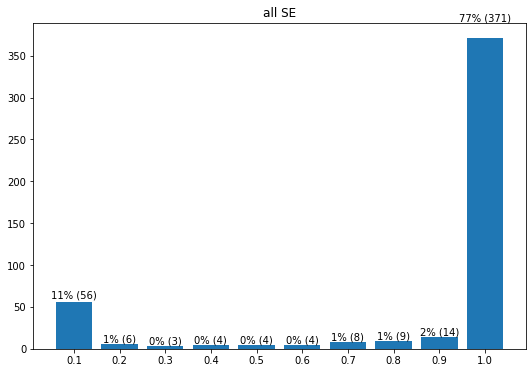

In [62]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
A = plt.bar([str(interv[1]) for interv in intervals], interv_scores_p)
createLabels(A)
plt.title('all SE')

I0507 06:30:56.868125 140575364511552 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0507 06:30:56.870328 140575364511552 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'not SE')

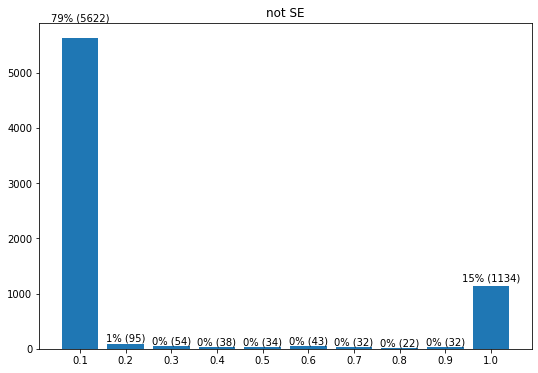

In [63]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
B = plt.bar([str(interv[1]) for interv in intervals], interv_scores_n)
createLabels(B)
plt.title('not SE')

I0507 06:30:57.644375 140575364511552 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0507 06:30:57.646412 140575364511552 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'answer SE')

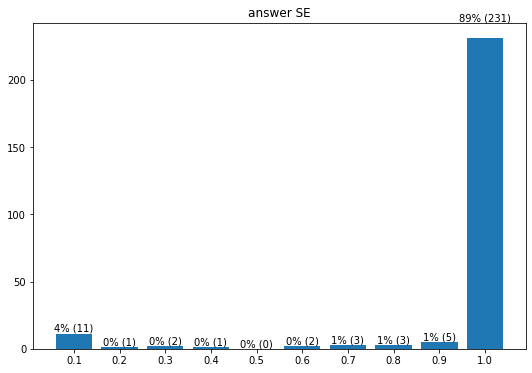

In [64]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
B = plt.bar([str(interv[1]) for interv in intervals], interv_scores_answer)
createLabels(B)
plt.title('answer SE')

I0507 06:30:58.508523 140575364511552 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0507 06:30:58.511134 140575364511552 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'SE but not answer SE')

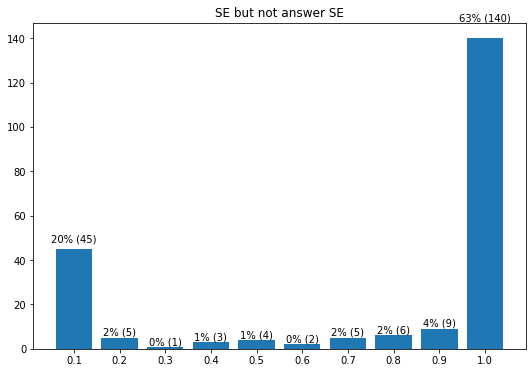

In [65]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
B = plt.bar([str(interv[1]) for interv in intervals], interv_scores_not_answer)
createLabels(B)
plt.title('SE but not answer SE')

In [66]:
low_score_eval_data = [data_to_eval[i] for i in low_score_data]

In [67]:
def clean_no_sp(data):
    out_data = []
    for d in data:
        for q in d['QUESTIONS']:
            if not q['SHINT_']:
                continue
            out_data.append(d)
    return out_data

In [68]:
data_to_eval = clean_no_sp(data_to_eval)

In [69]:
len(data_to_eval)

239

In [70]:
len(low_score_eval_data)

8

In [71]:
low_score_split_data = split_data_by_atype(low_score_eval_data)

In [72]:
split_eval_data = split_data_by_atype(data_to_eval)

In [73]:
len(low_score_data)

8

In [74]:
for k in split_eval_data.keys():
    print(k)
    print(len(split_eval_data[k]))

Person
27
Date-Duration
26
Location
30
Organization
19
Num-Measure
27
YesNo
28
Kinship
27
Event
2
Object
48
Misc
5


In [75]:
for k in low_score_split_data.keys():
    print(k)
    print(len(low_score_split_data[k]))

Person
0
Date-Duration
3
Location
0
Organization
0
Num-Measure
2
YesNo
0
Kinship
1
Event
1
Object
1
Misc
0


In [47]:
write_analysis(model_name+'_low_score_answer2ent.txt', low_score_eval_data, 'only')

# Try extract model

In [ ]:
items = [item for item in extractor.dataset_reader.get_items_in_q(q,d)]

In [ ]:
len(items)